# Sentiment Analysis Exercise  

The goal of the Sentiment Analysis (SA) task is to classify the sentiment within a piece of text. This sentiment can be either binary (positive-negative) or multi-class (a rating scale from 1 to 5).
 
Data: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz
 
Steps to Solve This Exercise
1. Load data into a pandas DataFrame
2. Preprocessing & Vectorizing 
3. Building Model
4. Evaluation

Note: Submit only a single Jupyter Notebook file that can handle all tasks, including data downloading, preprocessing, and model training. (Submissions that do not follow the guidelines will receive a score of 0.)

# Install and Import

In [81]:
%pip install gdown pandas numpy seaborn matplotlib scikit-learn nltk tqdm xgboost joblib wget plotly requests scipy

In [ ]:
# Import libraries
import sys
import os
import platform
import gzip
import re
import joblib
import json
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import plotly.express as px

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

from scipy.sparse import issparse

In [3]:
tqdm.pandas(desc="Processing text")

In [4]:
pd.set_option("max_colwidth", None)

In [5]:
# Python environment details
print("Python executable being used:", sys.executable)
print("Python version:", sys.version)

# Operating System details
print("Operating System:", platform.system())
print("OS Version:", platform.version())
print("OS Release:", platform.release())

# Machine and architecture details
print("Machine:", platform.machine())

# Visual Studio Code details (based on environment variable)
vscode_info = os.environ.get('VSCODE_PID', None)
if vscode_info:
    print("Running in Visual Studio Code")
else:
    print("Not running in Visual Studio Code")

Python executable being used: e:\anaconda3\envs\ml_env_test\python.exe
Python version: 3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:48:34) [MSC v.1929 64 bit (AMD64)]
Operating System: Windows
OS Version: 10.0.19045
OS Release: 10
Machine: AMD64
Running in Visual Studio Code


# Load data

In [6]:
# Download the dataset
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz"
filename = "reviews_Digital_Music_5.json.gz"

# Check if the file already exists
if not os.path.exists(filename):
    print("Downloading dataset...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                f.write(chunk)
        print(f"Dataset downloaded and saved as {filename}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File already exists: {filename}")


File already exists: reviews_Digital_Music_5.json.gz


In [7]:
# Load JSON file
def load_data(file_path):
    data = []
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load the dataset into a DataFrame
df = load_data(filename)

# Display basic info
print("\nDataset Sample:")
print(df.head())


Dataset Sample:
       reviewerID        asin          reviewerName helpful  \
0  A3EBHHCZO6V2A4  5555991584  Amaranth "music fan"  [3, 3]   
1   AZPWAXJG9OJXV  5555991584             bethtexas  [0, 0]   
2  A38IRL0X2T4DPF  5555991584           bob turnley  [2, 2]   
3  A22IK3I6U76GX0  5555991584                 Calle  [1, 1]   
4  A1AISPOIIHTHXX  5555991584           Cloud "..."  [1, 1]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

# Preprocess

In [8]:
df1 = df[['reviewText', 'overall']]
df1.head()

,reviewText,overall
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5.0
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5.0
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",5.0
3,"This is the third review of an irish album I write today (the others were Cranberries) and now I'm sure about that Ireland is one of the countries producing the best music in the world. And not just commercial pop-music in the Spice Girls way. Okay, I just wanted to say something about Irish music. Now let's say something about this album. It's great. it's beautiful. Very good, easy listened music. If you like Enya or you just want some easy-listened relaxing music. This is the album for you to buy!",5.0
4,"Enya, despite being a successful recording artist, doesn't have the broad appeal as other artists; one reason might be that her kind of music is not very pop station friendly while another reason could be people think they're too ""macho"" for music that she makes. But people with open minds could find there's some beautiful melodies and harmonies as well as lively, upbeat tunes that are a joy to put on. I find the Memory of Trees to be one of her most consistent albums; plus it helps it has probably one of my top 5 favorite songs ever.The Memory of Trees: Like all of her records (except the recent Amarantine), the albums open with a wordless instrumental and this album's title track is probably my favorite with gentle piano arpeggios and a beautiful vocal track. I always like the sparse use of percussion. 9/10Anywhere Is: The lively single; it's actually a good sing-along with staccato beats and a great chorus. It's also a perfect length since it's under 3 minutes so whereas some pop songs drag after awhile, this one hooks you in then lets you go, leaving you wanting more. 9/10Pax Deorum: Another album, another ominous Latin-sung piece. The music sounds like something you'd hear in enemy territories in video games while Enya gives a low-voice, almost monotone performance over the music. Slightly repetitive until a 2nd higher voice comes in but the piece hits its stride halfwa

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64706 non-null  object 
 1   overall     64706 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1011.2+ KB


In [10]:
df1['overall'].unique()

array([5., 4., 3., 1., 2.])

In [11]:
value_counts = df1['overall'].value_counts()
print(value_counts)

overall
5.0    35580
4.0    16536
3.0     6789
2.0     3010
1.0     2791
Name: count, dtype: int64


Create a sentiment column: 0 for value <= 3 of overall and 1 for the rest

In [12]:
# Convert ratings to binary sentiment (1-3 = negative, 4-5 = positive)
df1['sentiment'] = df1['overall'].apply(lambda x: 1 if x > 3 else 0)


C:\Users\User\AppData\Local\Temp\ipykernel_10420\3116498781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['sentiment'] = df1['overall'].apply(lambda x: 1 if x > 3 else 0)


In [13]:
value_counts = df1['sentiment'].value_counts()
print(value_counts)

sentiment
1    52116
0    12590
Name: count, dtype: int64


In [14]:
def remove_special_characters(text):
    """
    Remove special characters and punctuation from text.
    """
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r'http\S+|https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'\n|\t|\r|\f|\b', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text.strip()

def lowercase_text(text):
    """
    Convert text to lowercase.
    """
    return text.lower()

def tokenize_text(text):
    """
    Tokenize text into words.
    """
    return word_tokenize(text)

def remove_stopwords(words, language="english"):
    """
    Remove stopwords from a list of words.
    """
    stop_words = set(stopwords.words(language))
    return [word for word in words if word not in stop_words]

def stem_words(words):
    """
    Apply stemming to a list of words.
    Stemming reduces words to their base form using rule-based heuristics.
    """
    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """
    Apply lemmatization to a list of words.
    Lemmatization reduces words to their dictionary form using linguistic rules.
    """
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def remove_html_tags(text):
    """ 
    Remove html tags from text
    """
    clean_text = re.sub(r'<.*?>', '', text)
    return clean_text

def remove_mention(text):
    """ 
    Remove @mentions
    """
    # Remove @mentions
    clean_text = re.sub(r'@\w+', '', text)
    return clean_text

def remove_urls(text):
    """ 
    Remove urls from text
    """
    clean_text = re.sub(r'http\S+', '', text)
    return clean_text

def replace_chat_words(text):
    chat_words = {
        "BRB": "Be right back",
        "BTW": "By the way",
        "OMG": "Oh my God/goodness",
        "TTYL": "Talk to you later",
        "OMW": "On my way",
        "SMH/SMDH": "Shaking my head/shaking my darn head",
        "LOL": "Laugh out loud",
        "TBD": "To be determined", 
        "IMHO/IMO": "In my humble opinion",
        "HMU": "Hit me up",
        "IIRC": "If I remember correctly",
        "LMK": "Let me know", 
        "OG": "Original gangsters (used for old friends)",
        "FTW": "For the win", 
        "NVM": "Nevermind",
        "OOTD": "Outfit of the day", 
        "Ngl": "Not gonna lie",
        "Rq": "real quick", 
        "Iykyk": "If you know, you know",
        "Ong": "On god (I swear)", 
        "YAAAS": "Yes!", 
        "Brt": "Be right there",
        "Sm": "So much",
        "Ig": "I guess",
        "Wya": "Where you at",
        "Istg": "I swear to god",
        "Hbu": "How about you",
        "Atm": "At the moment",
        "Asap": "As soon as possible",
        "Fyi": "For your information",
        "Tbh": "To be honest",
        "Wtf": "What the fuck",
        "Idk": "I don't know"
    }
    for word, expanded_form in chat_words.items():
        text = text.replace(word, expanded_form)
    return text

def text_preprocessing(
    text,
    remove_special=True,
    to_lowercase=True,
    remove_stopwords_flag=True,
    stem_flag=False,
    lemmatize_flag=False,
    tokenize_flag=True,
    language="english",
):
    """
    Perform text preprocessing with multiple configurable steps.

    :param text: The input text string to preprocess.
    :param remove_special: Whether to remove special characters.
    :param to_lowercase: Whether to convert the text to lowercase.
    :param remove_stopwords_flag: Whether to remove stopwords from the text.
    :param stem_flag: Whether to apply stemming.
    :param lemmatize_flag: Whether to apply lemmatization.
    :param tokenize_flag: Whether to tokenize the text into words.
    :param language: Language to use for stopwords and tokenization.
    :return: Preprocessed text.
    """
    # Split the text into sentences for better handling of long texts
    sentences = sent_tokenize(text)

    processed_sentences = []
    for sentence in sentences: # only one loop here cause we extract only 1 sentence
        # Step 1: Remove special characters
        sentence = remove_mention(sentence)
        sentence = remove_html_tags(sentence)
        sentence = remove_urls(sentence)
        sentence = replace_chat_words(sentence)
        
        if remove_special:
            sentence = remove_special_characters(sentence)
        
        # Step 2: Convert to lowercase
        if to_lowercase:
            sentence = lowercase_text(sentence)
        
        # Step 3: Tokenize the sentence into words
        words = tokenize_text(sentence)
        
        # Step 4: Remove stopwords
        if remove_stopwords_flag:
            words = remove_stopwords(words, language)
        
        # Step 5: Apply stemming
        if stem_flag:
            words = stem_words(words)
        
        # Step 6: Apply lemmatization
        if lemmatize_flag:
            words = lemmatize_words(words)
        
        # Step 7: Reconstruct the sentence from words
        processed_sentences.append(" ".join(words))

    # Merge sentences back into text
    return " ".join(processed_sentences)




In [15]:
# Example text
text = """
This is an example sentence to demonstrate text preprocessing!
It includes punctuation, CAPITALIZED words, and stopwords.
"""

processed_text = text_preprocessing(
    text,
    remove_special=True,
    to_lowercase=True,
    remove_stopwords_flag=False,
    stem_flag=False,
    lemmatize_flag=True,
)

print("Original Text:\n", text)
print("Processed Text:\n", processed_text)

Original Text:
 
This is an example sentence to demonstrate text preprocessing!
It includes punctuation, CAPITALIZED words, and stopwords.

Processed Text:
 this is an example sentence to demonstrate text preprocessing it includes punctuation capitalized word and stopwords


In [16]:
# Convert ratings to binary sentiment (1-3 = negative, 4-5 = positive)
df1.head()

,reviewText,overall,sentiment
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",5.0,1
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",5.0,1
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",5.0,1
3,"This is the third review of an irish album I write today (the others were Cranberries) and now I'm sure about that Ireland is one of the countries producing the best music in the world. And not just commercial pop-music in the Spice Girls way. Okay, I just wanted to say something about Irish music. Now let's say something about this album. It's great. it's beautiful. Very good, easy listened music. If you like Enya or you just want some easy-listened relaxing music. This is the album for you to buy!",5.0,1
4,"Enya, despite being a successful recording artist, doesn't have the broad appeal as other artists; one reason might be that her kind of music is not very pop station friendly while another reason could be people think they're too ""macho"" for music that she makes. But people with open minds could find there's some beautiful melodies and harmonies as well as lively, upbeat tunes that are a joy to put on. I find the Memory of Trees to be one of her most consistent albums; plus it helps it has probably one of my top 5 favorite songs ever.The Memory of Trees: Like all of her records (except the recent Amarantine), the albums open with a wordless instrumental and this album's title track is probably my favorite with gentle piano arpeggios and a beautiful vocal track. I always like the sparse use of percussion. 9/10Anywhere Is: The lively single; it's actually a good sing-along with staccato beats and a great chorus. It's also a perfect length since it's under 3 minutes so whereas some pop songs drag after awhile, this one hooks you in then lets you go, leaving you wanting more. 9/10Pax Deorum: Another album, another ominous Latin-sung piece. The music sounds like something you'd hear in enemy territories in video games while Enya gives a low-voice, almost monotone performance over the music. Slightly repetitive until a 2nd higher voice comes in but the piece hits

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64706 non-null  object 
 1   overall     64706 non-null  float64
 2   sentiment   64706 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [18]:
# # Rename 'text' to 'reviewText' safely
# df1 = df1.rename(columns={"text": "reviewText"})

# # Check if 'reviewText' column exists after renaming
# if "reviewText" not in df1.columns:
#     raise KeyError("Column 'text' was not found in the DataFrame.")

# # Apply text preprocessing
# df1['text_clean'] = df1['reviewText'].astype(str).progress_apply(lambda x: text_preprocessing(
#     text=x,
#     remove_special=True,
#     to_lowercase=True,
#     remove_stopwords_flag=False,
#     tokenize_flag=True,
#     stem_flag=False,
#     lemmatize_flag=True
# ))

In [19]:
# df1.head()

In [20]:
# df1.info()

# Vectorizer

In [21]:
# # Adjust overall ratings to start from 0
# df1['overall'] = df1['overall'] - 1  # Shifts [1,2,3,4,5] -> [0,1,2,3,4]


In [22]:
# df1.head()

In [23]:
# # Save DataFrame to CSV
# csv_save_path = "df1.csv"
# df1.to_csv(csv_save_path, index=False)

# print(f"✅ Results saved to {csv_save_path}")

In [24]:
df1 = pd.read_csv("df1.csv")
df1.head()

,reviewText,overall,sentiment,text_clean
0,"It's hard to believe ""Memory of Trees"" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of ""Amarantine"" and ""Day without rain."" Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song.""Memory of Trees"" is elegaic&majestic.;""Pax Deorum"" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a ""disconcerting"" blend of spirituality&sensuality;,I don't find it disconcerting at all.""Anywhere is"" is a hopeful song,looking to possibilities.""Hope has a place"" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song.""On my way home"" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!",4.0,1,it hard to believe memory of tree came out year agoit ha held up well over the passage of timeits enyas last great album before the new agepop of amarantine and day without rain back in still had her creative sparkher own voicei agree with the reviewer who said that this is her saddest albumit is melancholybittersweetfrom the opening title song memory of tree is elegaicmajestic pax deorum sound like it is from a requiem massit is a dark threnodyunlike the reviewer who said that this ha a disconcerting blend of spiritualitysensualityi dont find it disconcerting at all anywhere is is a hopeful songlooking to possibility hope ha a place is about lovebut it is up to the listener to decide if it is romanticplatonicetcive always had a soft spot for this song on my way home is a triumphant ending about returnthis is truly a masterpiece of new age musica must for any enya fan
1,"A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety. Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice. But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe. But if you're already a fan, then your collection is not complete without this beautiful work of musical art.",4.0,1,a clasicallystyled and introverted album memory of tree is a masterpiece of subtlety many of the song have an endearing shyness to them soft piano and a lovely quiet voice but within every introvert is an inferno and enya let that fire explode on a couple of song that absolutely burst with an expected raw powerif youve never heard enya before you might want to start with one of her more popularized work like watermark just to play it safe but if youre already a fan then your collection is not complete without this beautiful work of musical art
2,"I never thought Enya would reach the sublime heights of Evacuee or Marble Halls from 'Shepherd Moons.' 'The Celts, Watermark and Day...' were all pleasant and admirable throughout, but are less ambitious both lyrically and musically. But Hope Has a Place from 'Memory...' reaches those heights and beyond. It is Enya at her most inspirational and comforting. I'm actually glad that this song didn't get overexposed the way Only Time did. It makes it that much more special to all who own this album.",4.0,1,i never thought enya would reach the sublime height of evacuee or marble hall from shepherd moon the celt watermark and day were all pleasant and admirable throughout but are less ambitious both lyrically and musically but hope ha a place from memory reach those height and beyond it is enya at her most inspirational and comforting im actually glad that this song didnt get overexposed the way only time did it make it that much more special to all who own

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64706 entries, 0 to 64705
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64705 non-null  object 
 1   overall     64706 non-null  float64
 2   sentiment   64706 non-null  int64  
 3   text_clean  64705 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.0+ MB


In [26]:
df_cleaned = df1.dropna(subset=['reviewText'])
print(df_cleaned.info())
df1 = df_cleaned

<class 'pandas.core.frame.DataFrame'>
Index: 64705 entries, 0 to 64705
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  64705 non-null  object 
 1   overall     64705 non-null  float64
 2   sentiment   64705 non-null  int64  
 3   text_clean  64705 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.5+ MB
None


In [27]:
# Step 1: Vectorization using TF-IDF
# vectorizer = TfidfVectorizer(max_features=5000)
vectorizer = TfidfVectorizer(max_features=5000)
TRAIN = vectorizer.fit_transform(df1['text_clean'])

In [28]:
# Step 2: Train-Test Split for `overall` prediction
X_train_tfidf, X_test_tfidf, y_train_overall, y_test_overall = train_test_split(
    TRAIN, df1['overall'], test_size=0.2, random_state=42
)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)
print("y_train shape:", y_train_overall.shape)
print("y_test shape:", y_test_overall.shape)

X_train_tfidf shape: (51764, 5000)
X_test_tfidf shape: (12941, 5000)
y_train shape: (51764,)
y_test shape: (12941,)


# Build Models for 2 Tasks (classification on overall score and classification on sentiment - sentiment analysis)

I have read here on the link and get the information about models used for multiclass classification and then i try to run all of them

https://scikit-learn.org/stable/modules/multiclass.html

**Select or Comment the Models here to choose the ones to use on the 2 tasks**

In [ ]:
# Define models for multiclass classification
models_chosen = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="saga", tol=1e-3, random_state=42),
    "BernoulliNB": BernoulliNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=10, random_state=42),
    "ExtraTreeClassifier": ExtraTreeClassifier(max_depth=10, random_state=42),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42),
    "GaussianNB": GaussianNB(var_smoothing=1e-9),
    "LinearSVC": LinearSVC(multi_class="crammer_singer", max_iter=2000, tol=1e-3, dual=False, random_state=42),
    "NearestCentroid": NearestCentroid(),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, max_depth=10, max_features="sqrt", random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, learning_rate_init=0.01, early_stopping=True, random_state=42)
}

## Build Model for classification by overall score

### Train the Model for classify text by their overall score

In [ ]:
# Define models for multiclass classification
models_overall = models_chosen

In [ ]:
# For overall score classification
results_overall = {}
best_model_overall = None
best_accuracy_overall_score = 0
trained_models_overall_score = {}  


In [31]:
for model_name, model in models_overall.items():
    print(f"Training and evaluating {model_name}...")

    # K-Fold Cross-Validation
    accuracy_scores, roc_auc_scores, f1_scores = [], [], []
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in tqdm(k_fold.split(X_train_tfidf), total=k_fold.get_n_splits(), desc="K-Fold Progress"):
        X_train, X_val = X_train_tfidf[train_index], X_train_tfidf[val_index]
        y_train, y_val = y_train_overall.iloc[train_index], y_train_overall.iloc[val_index]

        # Convert to dense format ONLY for models that require it
        if isinstance(model, (GaussianNB, MLPClassifier, NearestCentroid)):
            if issparse(X_train):  # Check if it's sparse
                X_train = X_train.toarray()
                X_val = X_val.toarray()

        # Scale data ONLY for distance-based models
        if isinstance(model, (RadiusNeighborsClassifier, KNeighborsClassifier)):
            scaler = StandardScaler(with_mean=False) # handle sparse matrix
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)

        accuracy_scores.append(accuracy_score(y_val, val_preds))
        
        if hasattr(model, "predict_proba"):  
            val_probs = model.predict_proba(X_val)
            # roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')
            # Skip ROC AUC calculation if probabilities don't sum to 1
            if not np.allclose(1, val_probs.sum(axis=1)):
                print(f"⚠️ Skipping ROC AUC for {model_name} due to invalid probabilities.")
                roc_auc = None
            else:
                roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')
        else:
            roc_auc = None  

        f1_scores.append(f1_score(y_val, val_preds, average='weighted'))
        if roc_auc is not None:
            roc_auc_scores.append(roc_auc)

    # Compute average scores
    avg_acc = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    avg_roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else None

    # Store trained model
    trained_models_overall_score[model_name] = model  # ✅ Save trained model
    results_overall[model_name] = {
        "Accuracy": avg_acc,
        "F1 Score": avg_f1,
        "ROC AUC": avg_roc_auc,
        "Accuracy Scores": accuracy_scores,
        "F1 Scores": f1_scores,
        "ROC AUC Scores": roc_auc_scores
    }

    # Update Best Model
    if avg_acc > best_accuracy_overall_score:
        best_accuracy_overall_score = avg_acc
        best_model_overall = model_name

print(f"\n🏆 Best Model: {best_model_overall} with Accuracy: {best_accuracy_overall_score:.3f}")

Training and evaluating LogisticRegression...


K-Fold Progress: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Training and evaluating BernoulliNB...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Training and evaluating DecisionTreeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [01:28<00:00, 17.67s/it]


Training and evaluating ExtraTreeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Training and evaluating ExtraTreesClassifier...


K-Fold Progress: 100%|██████████| 5/5 [01:00<00:00, 12.20s/it]


Training and evaluating GaussianNB...


K-Fold Progress: 100%|██████████| 5/5 [01:44<00:00, 20.87s/it]


Training and evaluating LinearSVC...


K-Fold Progress:   0%|          | 0/5 [00:00<?, ?it/s]e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
K-Fold Progress:  20%|██        | 1/5 [00:13<00:52, 13.19s/it]e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
K-Fold Progress:  40%|████      | 2/5 [00:30<00:45, 15.33s/it]e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
K-Fold Progress:  60%|██████    | 3/5 [00:45<00:31, 15.60s/it]e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
K-Fold Progress:  80%|████████  | 4/5 [01:00<00:15, 

Training and evaluating NearestCentroid...


K-Fold Progress: 100%|██████████| 5/5 [00:20<00:00,  4.11s/it]


Training and evaluating RidgeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:38<00:00,  7.61s/it]


Training and evaluating RandomForestClassifier...


K-Fold Progress: 100%|██████████| 5/5 [02:20<00:00, 28.01s/it]


Training and evaluating MLPClassifier...


K-Fold Progress: 100%|██████████| 5/5 [08:47<00:00, 105.45s/it]


🏆 Best Model: MLPClassifier with Accuracy: 0.636


### Visualize some performance metrics of the models for classify the text overall score

Result of Training and evaluating LogisticRegression...
📊 LogisticRegression - Average Accuracy: 0.635
📊 LogisticRegression - Average F1 Score: 0.604
📊 LogisticRegression - Average ROC AUC: 0.845
Result of Training and evaluating BernoulliNB...
📊 BernoulliNB - Average Accuracy: 0.349
📊 BernoulliNB - Average F1 Score: 0.392
📊 BernoulliNB - Average ROC AUC: 0.679
Result of Training and evaluating DecisionTreeClassifier...
📊 DecisionTreeClassifier - Average Accuracy: 0.554
📊 DecisionTreeClassifier - Average F1 Score: 0.475
📊 DecisionTreeClassifier - Average ROC AUC: 0.640
Result of Training and evaluating ExtraTreeClassifier...
📊 ExtraTreeClassifier - Average Accuracy: 0.548
📊 ExtraTreeClassifier - Average F1 Score: 0.404
📊 ExtraTreeClassifier - Average ROC AUC: 0.555
Result of Training and evaluating ExtraTreesClassifier...
📊 ExtraTreesClassifier - Average Accuracy: 0.549
📊 ExtraTreesClassifier - Average F1 Score: 0.389
📊 ExtraTreesClassifier - Average ROC AUC: 0.782
Result of Training a

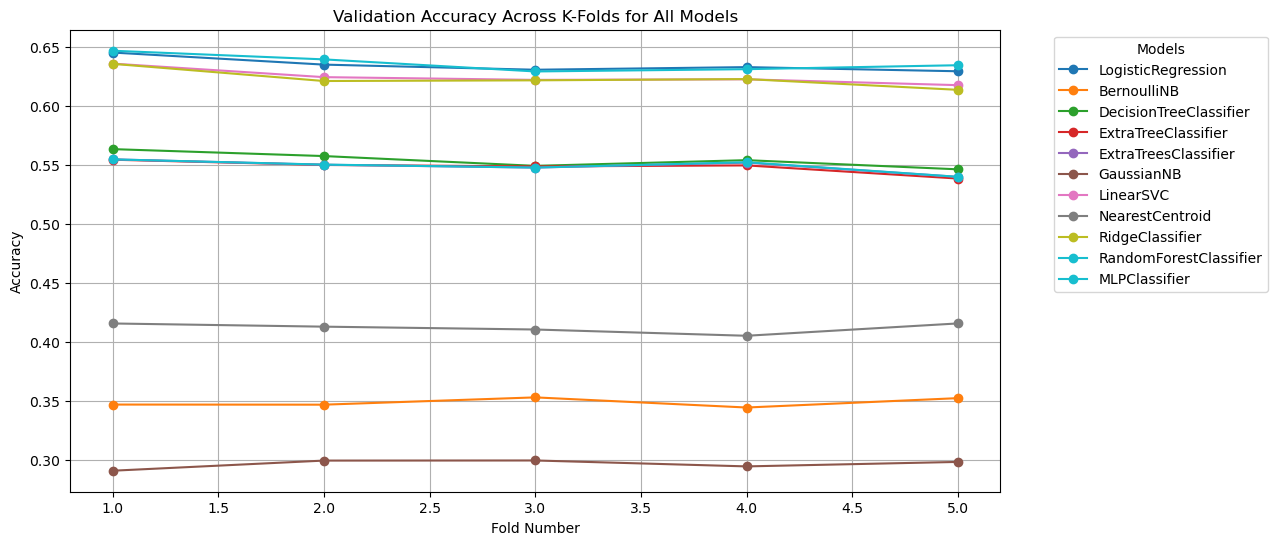

In [32]:
# Define color map for different models
num_models = len(models_overall)
colors = plt.cm.tab10(np.linspace(0, 1, num_models))  # Generate unique colors

# Create a figure for Accuracy
plt.figure(figsize=(12, 6))
plt.title("Validation Accuracy Across K-Folds for All Models")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.grid(True)

# Iterate over each model and assign a unique color for Accuracy
for idx, (model_name, model) in enumerate(models_overall.items()):
    color = colors[idx]

    # Print evaluation results
    print(f"Result of Training and evaluating {model_name}...")
    print(f'📊 {model_name} - Average Accuracy: {results_overall[model_name]["Accuracy"]:.3f}')
    print(f'📊 {model_name} - Average F1 Score: {results_overall[model_name]["F1 Score"]:.3f}')
    if results_overall[model_name]["ROC AUC"]:
        print(f'📊 {model_name} - Average ROC AUC: {results_overall[model_name]["ROC AUC"]:.3f}')
    else:
        print(f'📊 {model_name} - Average ROC AUC: N/A')

    # Plot Accuracy
    plt.plot(range(1, len(results_overall[model_name]["Accuracy Scores"]) + 1), 
             results_overall[model_name]["Accuracy Scores"], 
             label=f"{model_name}", marker='o', linestyle='-', color=color)

# Add legend and show Accuracy plot
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


📊 LogisticRegression - Average ROC AUC: 0.845
📊 BernoulliNB - Average ROC AUC: 0.679
📊 DecisionTreeClassifier - Average ROC AUC: 0.640
📊 ExtraTreeClassifier - Average ROC AUC: 0.555
📊 ExtraTreesClassifier - Average ROC AUC: 0.782
📊 GaussianNB - Average ROC AUC: 0.588
📊 LinearSVC - Average ROC AUC: N/A
📊 NearestCentroid - Average ROC AUC: N/A
📊 RidgeClassifier - Average ROC AUC: N/A
📊 RandomForestClassifier - Average ROC AUC: 0.780
📊 MLPClassifier - Average ROC AUC: 0.848


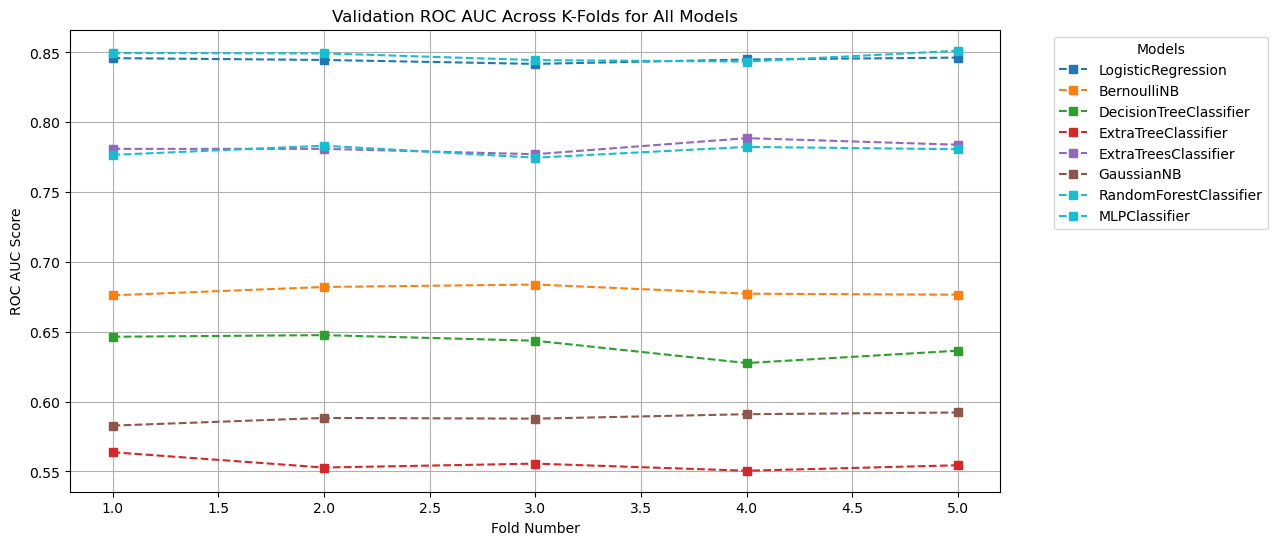

In [33]:
# ---------------------- ROC AUC PLOT ----------------------

# Create a figure for ROC AUC
plt.figure(figsize=(12, 6))
plt.title("Validation ROC AUC Across K-Folds for All Models")
plt.xlabel("Fold Number")
plt.ylabel("ROC AUC Score")
plt.grid(True)

# Iterate over models again for ROC AUC
for idx, (model_name, model) in enumerate(models_overall.items()):
    color = colors[idx]
    
    # Handle ROC AUC None values
    roc_auc = results_overall[model_name]["ROC AUC"]
    roc_auc_str = f"{roc_auc:.3f}" if roc_auc is not None else "N/A"
    print(f'📊 {model_name} - Average ROC AUC: {roc_auc_str}')
    
    # Plot ROC AUC only if it exists
    if results_overall[model_name]["ROC AUC Scores"]:
        plt.plot(range(1, len(results_overall[model_name]["ROC AUC Scores"]) + 1), 
                 results_overall[model_name]["ROC AUC Scores"], 
                 label=f"{model_name}", marker='s', linestyle='--', color=color)

# Add legend and show ROC AUC plot
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Print the best model
# print(f"\n🏆 Best Model: {best_model_overall} with Accuracy: {best_accuracy_overall_score:.3f}")


### Test the Model on the Test Set

In [34]:
# ✅ Use the trained models to test on X_test_tfidf
test_results_ovr_score = {}

for model_name, model in trained_models_overall_score.items():
    print(f"\n🔍 Testing {model_name} on Test Data...")

    # Convert to dense format ONLY for models that require it
    if isinstance(model, (GaussianNB, MLPClassifier, NearestCentroid)):
        if issparse(X_test_tfidf):  # Check if sparse
            X_test_tfidf = X_test_tfidf.toarray()

    # Scale data ONLY for distance-based models
    if isinstance(model, (RadiusNeighborsClassifier, KNeighborsClassifier)):
        scaler = StandardScaler()
        X_test_tfidf = scaler.fit_transform(X_test_tfidf)

    # Make Predictions
    y_test_pred = model.predict(X_test_tfidf)

    # Compute Metrics
    test_accuracy = accuracy_score(y_test_overall, y_test_pred)
    test_f1 = f1_score(y_test_overall, y_test_pred, average='weighted')
    
    if hasattr(model, "predict_proba"):
        y_test_probs = model.predict_proba(X_test_tfidf)
        test_roc_auc = roc_auc_score(y_test_overall, y_test_probs, multi_class='ovr')
    else:
        test_roc_auc = None  # Skip if model does not support probability prediction
    
    # Store Results
    test_results_ovr_score[model_name] = {
        "Test Accuracy": test_accuracy,
        "Test F1 Score": test_f1,
        "Test ROC AUC": test_roc_auc if test_roc_auc else "N/A"
    }
    
    print(f"📊 {model_name} - Test Accuracy: {test_accuracy:.3f}, Test F1 Score: {test_f1:.3f}")



🔍 Testing LogisticRegression on Test Data...
📊 LogisticRegression - Test Accuracy: 0.637, Test F1 Score: 0.607

🔍 Testing BernoulliNB on Test Data...
📊 BernoulliNB - Test Accuracy: 0.349, Test F1 Score: 0.394

🔍 Testing DecisionTreeClassifier on Test Data...
📊 DecisionTreeClassifier - Test Accuracy: 0.556, Test F1 Score: 0.469

🔍 Testing ExtraTreeClassifier on Test Data...
📊 ExtraTreeClassifier - Test Accuracy: 0.551, Test F1 Score: 0.404

🔍 Testing ExtraTreesClassifier on Test Data...
📊 ExtraTreesClassifier - Test Accuracy: 0.554, Test F1 Score: 0.395

🔍 Testing GaussianNB on Test Data...
📊 GaussianNB - Test Accuracy: 0.302, Test F1 Score: 0.357

🔍 Testing LinearSVC on Test Data...
📊 LinearSVC - Test Accuracy: 0.628, Test F1 Score: 0.600

🔍 Testing NearestCentroid on Test Data...
📊 NearestCentroid - Test Accuracy: 0.413, Test F1 Score: 0.451

🔍 Testing RidgeClassifier on Test Data...
📊 RidgeClassifier - Test Accuracy: 0.625, Test F1 Score: 0.585

🔍 Testing RandomForestClassifier on T

### Comparison of the test models

In [ ]:
# Create a DataFrame to store the comparison of ROC-AUC scores for different vectorizers
# Format:
# test_results_ovr_score[model_name] = {
#     "Test Accuracy": test_accuracy,
#     "Test F1 Score": test_f1,
#     "Test ROC AUC": test_roc_auc if test_roc_auc else "N/A"
# }
comparison_df_ovr_score = pd.DataFrame({
    "Model": models_overall.keys(),
    "Test Accuracy": [test_results_ovr_score[model]["Test Accuracy"] for model in models_overall.keys()],
    "Test F1 Score": [test_results_ovr_score[model]["Test F1 Score"] for model in models_overall.keys()],
    "Test ROC AUC": [test_results_ovr_score[model]["Test ROC AUC"] for model in models_overall.keys()]
})

# Transpose the DataFrame
# comparison_df_ovr_score = comparison_df_ovr_score.set_index("Model").T

# Convert columns to numeric and fill NaN with a very small value (so they don't affect idxmax)
comparison_df_ovr_score[["Test Accuracy", "Test F1 Score", "Test ROC AUC"]] = (
    comparison_df_ovr_score[["Test Accuracy", "Test F1 Score", "Test ROC AUC"]]
    .apply(pd.to_numeric, errors='coerce')  # Convert to numeric (coerce errors to NaN)
    .fillna(0)  # Fill NaNs with 0 
)

# Set "Model" as index
comparison_df_ovr_score.set_index("Model", inplace=True)
best_models_per_metric = comparison_df_ovr_score.idxmax(axis=0)
best_models_df = pd.DataFrame(best_models_per_metric, columns=["Best Model"])


In [75]:
# Display both DataFrames
print("Overall Model Comparison")
print(comparison_df_ovr_score)
print("\n")
print("Best Models Per Metric")
print(best_models_df)

Overall Model Comparison
                        Test Accuracy  Test F1 Score  Test ROC AUC
Model                                                             
LogisticRegression           0.637354       0.607005      0.842963
BernoulliNB                  0.349432       0.393616      0.678599
DecisionTreeClassifier       0.555830       0.469234      0.633744
ExtraTreeClassifier          0.550962       0.404425      0.557374
ExtraTreesClassifier         0.553821       0.394792      0.781884
GaussianNB                   0.301831       0.356686      0.587924
LinearSVC                    0.628004       0.600389      0.000000
NearestCentroid              0.413183       0.450709      0.000000
RidgeClassifier              0.625068       0.585347      0.000000
RandomForestClassifier       0.553821       0.394831      0.776343
MLPClassifier                0.640831       0.616282      0.847800


Best Models Per Metric
                  Best Model
Test Accuracy  MLPClassifier
Test F1 Score  MLPCla

In [84]:
# Reset index so "Model" becomes a column
comparison_melted = comparison_df_ovr_score.reset_index().melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create an interactive 3D bar chart
fig = px.bar(comparison_melted, 
             x="Metric", 
             y="Score", 
             color="Model", 
             barmode="group",
             title="Comparison of Model Performance Across Metrics")

fig.update_layout(xaxis_title="Metrics", 
                  yaxis_title="Score", 
                  legend_title="Model",
                  hovermode="x unified")

fig.show()


## Build Model for classification by sentiment

### Train the Model for classify text by sentiment

In [58]:
# Step 2: Train-Test Split for `overall` prediction
X_train_sent, X_test_sent, y_train_overall_sent, y_test_overall_sent = train_test_split(
    TRAIN, df1['sentiment'], test_size=0.2, random_state=42
)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)
print("y_train shape:", y_train_overall.shape)
print("y_test shape:", y_test_overall.shape)

X_train_tfidf shape: (51764, 5000)
X_test_tfidf shape: (12941, 5000)
y_train shape: (51764,)
y_test shape: (12941,)


In [ ]:
# Define models for sentiment classification
models_sentiment = models_chosen

In [60]:
# Train and evaluate models using K-Fold Cross-Validation
results_sentiment = {}
best_model_sentiment = None
best_accuracy_sent = 0
trained_models_sentiment = {}  

In [61]:
for model_name, model in models_sentiment.items():
    print(f"Training and evaluating {model_name}...")

    # K-Fold Cross-Validation
    accuracy_scores, roc_auc_scores, f1_scores = [], [], []
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in tqdm(k_fold.split(X_train_sent), total=k_fold.get_n_splits(), desc="K-Fold Progress"):
        X_train, X_val = X_train_sent[train_index], X_train_sent[val_index]
        y_train, y_val = y_train_overall_sent.iloc[train_index], y_train_overall_sent.iloc[val_index]

        # Convert to dense format for models that require it
        if isinstance(model, (GaussianNB, MLPClassifier, NearestCentroid)):
            if issparse(X_train):  # Check if it's sparse
                X_train = X_train.toarray()
                X_val = X_val.toarray()

        # Scale data for distance-based models
        if isinstance(model, (RadiusNeighborsClassifier, KNeighborsClassifier)):
            scaler = StandardScaler(with_mean=False)  # Handle sparse matrix
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
 
        accuracy_scores.append(accuracy_score(y_val, val_preds))

        if hasattr(model, "predict_proba"):  
            val_probs = model.predict_proba(X_val)
            # Check probability sum validity before calculating ROC AUC
            if not np.allclose(1, val_probs.sum(axis=1)):
                print(f"⚠️ Skipping ROC AUC for {model_name} due to invalid probabilities.")
                roc_auc = None
            else:
                # roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr')
                
                if val_probs.ndim > 1:
                    val_probs = val_probs.argmax(axis=1)

                # Compute ROC AUC score
                roc_auc = roc_auc_score(y_val, val_probs, multi_class='ovr', average='weighted')

        else:
            roc_auc = None  

        f1_scores.append(f1_score(y_val, val_preds, average='weighted'))
        if roc_auc is not None:
            roc_auc_scores.append(roc_auc)

    # Compute average scores
    avg_acc = np.mean(accuracy_scores)
    avg_f1 = np.mean(f1_scores)
    avg_roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else None

    # Store trained model
    trained_models_sentiment[model_name] = model 
    results_sentiment[model_name] = {
        "Accuracy": avg_acc,
        "F1 Score": avg_f1,
        "ROC AUC": avg_roc_auc,
        "Accuracy Scores": accuracy_scores,
        "F1 Scores": f1_scores,
        "ROC AUC Scores": roc_auc_scores
    }

    # Update Best Model
    if avg_acc > best_accuracy_sent:
        best_accuracy_sent = avg_acc
        best_model_sentiment = model_name

print(f"\n🏆 Best Model: {best_model_sentiment} with Accuracy: {best_accuracy_sent:.3f}")

Training and evaluating LogisticRegression...


K-Fold Progress: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]


Training and evaluating BernoulliNB...


K-Fold Progress: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]


Training and evaluating DecisionTreeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [01:12<00:00, 14.48s/it]


Training and evaluating ExtraTreeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]


Training and evaluating ExtraTreesClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:30<00:00,  6.02s/it]


Training and evaluating GaussianNB...


K-Fold Progress: 100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


Training and evaluating LinearSVC...


K-Fold Progress: 100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


Training and evaluating NearestCentroid...


K-Fold Progress: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


Training and evaluating RidgeClassifier...


K-Fold Progress: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Training and evaluating RandomForestClassifier...


K-Fold Progress: 100%|██████████| 5/5 [01:15<00:00, 15.13s/it]


Training and evaluating MLPClassifier...


K-Fold Progress: 100%|██████████| 5/5 [07:57<00:00, 95.52s/it] 


🏆 Best Model: RidgeClassifier with Accuracy: 0.871


### Visualize some performance metrics of the models for classify the text based on the sentiment

Result of Training and evaluating LogisticRegression...
📊 LogisticRegression - Average Accuracy: 0.870
📊 LogisticRegression - Average F1 Score: 0.856
📊 LogisticRegression - Average ROC AUC: 0.714
Result of Training and evaluating BernoulliNB...
📊 BernoulliNB - Average Accuracy: 0.684
📊 BernoulliNB - Average F1 Score: 0.716
📊 BernoulliNB - Average ROC AUC: 0.703
Result of Training and evaluating DecisionTreeClassifier...
📊 DecisionTreeClassifier - Average Accuracy: 0.817
📊 DecisionTreeClassifier - Average F1 Score: 0.778
📊 DecisionTreeClassifier - Average ROC AUC: 0.581
Result of Training and evaluating ExtraTreeClassifier...
📊 ExtraTreeClassifier - Average Accuracy: 0.806
📊 ExtraTreeClassifier - Average F1 Score: 0.728
📊 ExtraTreeClassifier - Average ROC AUC: 0.511
Result of Training and evaluating ExtraTreesClassifier...
📊 ExtraTreesClassifier - Average Accuracy: 0.806
📊 ExtraTreesClassifier - Average F1 Score: 0.719
📊 ExtraTreesClassifier - Average ROC AUC: 0.500
Result of Training a

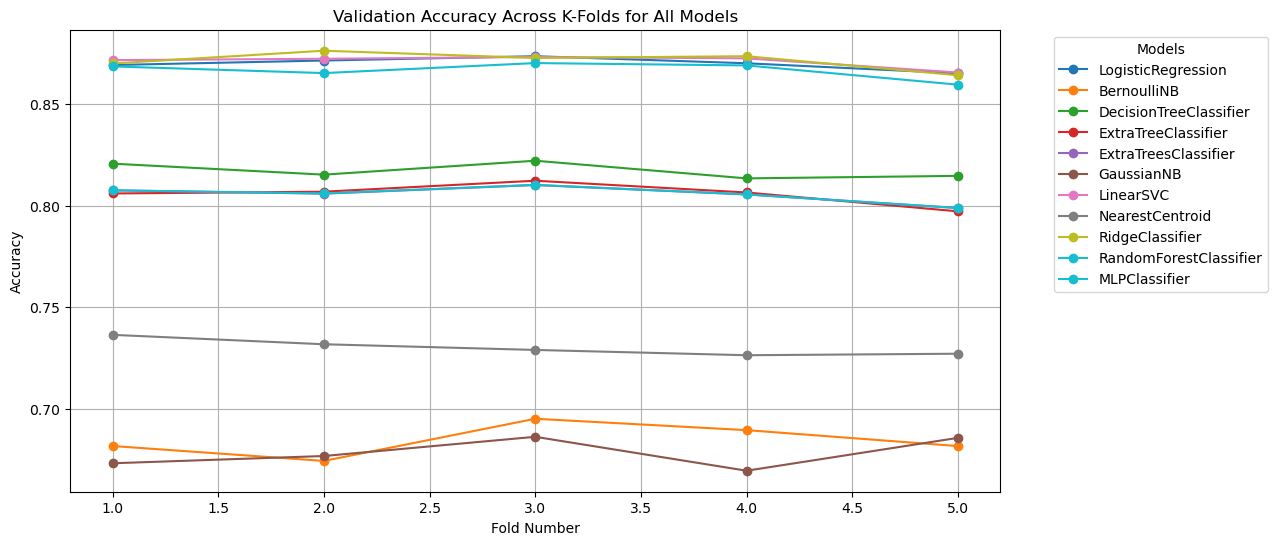

In [62]:
# Define color map for different models
num_models = len(models_sentiment)
colors = plt.cm.tab10(np.linspace(0, 1, num_models))  # Generate unique colors

# Create a figure for Accuracy
plt.figure(figsize=(12, 6))
plt.title("Validation Accuracy Across K-Folds for All Models")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.grid(True)

# Iterate over each model and assign a unique color for Accuracy
for idx, (model_name, model) in enumerate(trained_models_sentiment.items()):
    color = colors[idx]

    # Print evaluation results
    print(f"Result of Training and evaluating {model_name}...")
    print(f'📊 {model_name} - Average Accuracy: {results_sentiment[model_name]["Accuracy"]:.3f}')
    print(f'📊 {model_name} - Average F1 Score: {results_sentiment[model_name]["F1 Score"]:.3f}')
    if results_sentiment[model_name]["ROC AUC"]:
        print(f'📊 {model_name} - Average ROC AUC: {results_sentiment[model_name]["ROC AUC"]:.3f}')
    else:
        print(f'📊 {model_name} - Average ROC AUC: N/A')

    # Plot Accuracy
    plt.plot(range(1, len(results_sentiment[model_name]["Accuracy Scores"]) + 1), 
             results_sentiment[model_name]["Accuracy Scores"], 
             label=f"{model_name}", marker='o', linestyle='-', color=color)

# Add legend and show Accuracy plot
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


📊 LogisticRegression - Average ROC AUC: 0.714
📊 BernoulliNB - Average ROC AUC: 0.703
📊 DecisionTreeClassifier - Average ROC AUC: 0.581
📊 ExtraTreeClassifier - Average ROC AUC: 0.511
📊 ExtraTreesClassifier - Average ROC AUC: 0.500
📊 GaussianNB - Average ROC AUC: 0.681
📊 LinearSVC - Average ROC AUC: N/A
📊 NearestCentroid - Average ROC AUC: N/A
📊 RidgeClassifier - Average ROC AUC: N/A
📊 RandomForestClassifier - Average ROC AUC: 0.500
📊 MLPClassifier - Average ROC AUC: 0.743


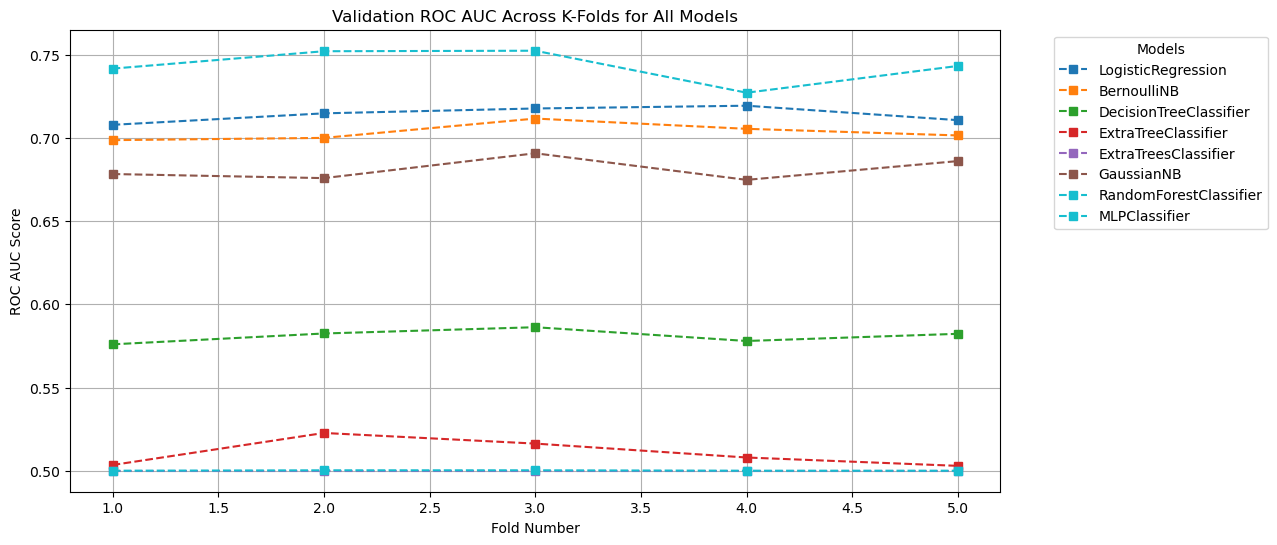

In [63]:
# ---------------------- ROC AUC PLOT ----------------------

# Create a figure for ROC AUC
plt.figure(figsize=(12, 6))
plt.title("Validation ROC AUC Across K-Folds for All Models")
plt.xlabel("Fold Number")
plt.ylabel("ROC AUC Score")
plt.grid(True)

# Iterate over models again for ROC AUC
for idx, (model_name, model) in enumerate(trained_models_sentiment.items()):
    color = colors[idx]
    
    # Handle ROC AUC None values
    roc_auc = results_sentiment[model_name]["ROC AUC"]
    roc_auc_str = f"{roc_auc:.3f}" if roc_auc is not None else "N/A"
    print(f'📊 {model_name} - Average ROC AUC: {roc_auc_str}')
    
    # Plot ROC AUC only if it exists
    if results_sentiment[model_name]["ROC AUC Scores"]:
        plt.plot(range(1, len(results_sentiment[model_name]["ROC AUC Scores"]) + 1), 
                 results_sentiment[model_name]["ROC AUC Scores"], 
                 label=f"{model_name}", marker='s', linestyle='--', color=color)

# Add legend and show ROC AUC plot
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Print the best model
# print(f"\n🏆 Best Model: {best_model_sentiment} with Accuracy: {best_accuracy:.3f}")


### Test the Model on the Test Set

In [65]:
# ✅ Use the trained models to test on X_test_tfidf
test_results_sent = {}

for model_name, model in trained_models_sentiment.items():
    print(f"\n🔍 Testing {model_name} on Test Data...")

    # Convert to dense format ONLY for models that require it
    if isinstance(model, (GaussianNB, MLPClassifier, NearestCentroid)):
        if issparse(X_test_sent):  # Check if sparse
            X_test_sent = X_test_sent.toarray()

    # Scale data ONLY for distance-based models
    if isinstance(model, (RadiusNeighborsClassifier, KNeighborsClassifier)):
        scaler = StandardScaler()
        X_test_sent = scaler.fit_transform(X_test_sent)

    # Make Predictions
    y_test_pred = model.predict(X_test_sent)

    # Compute Metrics
    test_accuracy = accuracy_score(y_test_overall_sent, y_test_pred)
    test_f1 = f1_score(y_test_overall_sent, y_test_pred, average='weighted')
    
    if hasattr(model, "predict_proba"):
        y_test_probs = model.predict_proba(X_test_sent)
        if y_test_probs.ndim > 1:
            y_test_probs = y_test_probs.argmax(axis=1)
        test_roc_auc = roc_auc_score(y_test_overall_sent, y_test_probs, multi_class='ovr')
    else:
        test_roc_auc = None  # Skip if model does not support probability prediction
    
    # Store Results
    test_results_sent[model_name] = {
        "Test Accuracy": test_accuracy,
        "Test F1 Score": test_f1,
        "Test ROC AUC": test_roc_auc if test_roc_auc else "N/A"
    }
    
    print(f"📊 {model_name} - Test Accuracy: {test_accuracy:.3f}, Test F1 Score: {test_f1:.3f}")



🔍 Testing LogisticRegression on Test Data...
📊 LogisticRegression - Test Accuracy: 0.873, Test F1 Score: 0.859

🔍 Testing BernoulliNB on Test Data...


📊 BernoulliNB - Test Accuracy: 0.689, Test F1 Score: 0.720

🔍 Testing DecisionTreeClassifier on Test Data...
📊 DecisionTreeClassifier - Test Accuracy: 0.818, Test F1 Score: 0.777

🔍 Testing ExtraTreeClassifier on Test Data...
📊 ExtraTreeClassifier - Test Accuracy: 0.805, Test F1 Score: 0.722

🔍 Testing ExtraTreesClassifier on Test Data...
📊 ExtraTreesClassifier - Test Accuracy: 0.805, Test F1 Score: 0.718

🔍 Testing GaussianNB on Test Data...
📊 GaussianNB - Test Accuracy: 0.683, Test F1 Score: 0.714

🔍 Testing LinearSVC on Test Data...
📊 LinearSVC - Test Accuracy: 0.873, Test F1 Score: 0.864

🔍 Testing NearestCentroid on Test Data...
📊 NearestCentroid - Test Accuracy: 0.736, Test F1 Score: 0.759

🔍 Testing RidgeClassifier on Test Data...
📊 RidgeClassifier - Test Accuracy: 0.872, Test F1 Score: 0.859

🔍 Testing RandomForestClassifier on Test Data...
📊 RandomForestClassifier - Test Accuracy: 0.805, Test F1 Score: 0.718

🔍 Testing MLPClassifier on Test Data...
📊 MLPClassifier - Test Accur

### Comparison of the test models

In [ ]:
# Create a DataFrame to store the comparison of ROC-AUC scores for different vectorizers
# Format:
# test_results_ovr_score[model_name] = {
#     "Test Accuracy": test_accuracy,
#     "Test F1 Score": test_f1,
#     "Test ROC AUC": test_roc_auc if test_roc_auc else "N/A"
# }
comparison_df_sent = pd.DataFrame({
    "Model": models_sentiment.keys(),
    "Test Accuracy": [test_results_sent[model]["Test Accuracy"] for model in models_sentiment.keys()],
    "Test F1 Score": [test_results_sent[model]["Test F1 Score"] for model in models_sentiment.keys()],
    "Test ROC AUC": [test_results_sent[model]["Test ROC AUC"] for model in models_sentiment.keys()]
})

# Convert columns to numeric and fill NaN with a very small value (so they don't affect idxmax)
comparison_df_sent[["Test Accuracy", "Test F1 Score", "Test ROC AUC"]] = (
    comparison_df_sent[["Test Accuracy", "Test F1 Score", "Test ROC AUC"]]
    .apply(pd.to_numeric, errors='coerce')  # Convert to numeric (coerce errors to NaN)
    .fillna(0)  # Fill NaNs with 0 
)

# Set "Model" as index
comparison_df_sent.set_index("Model", inplace=True)
best_models_per_metric_sent = comparison_df_sent.idxmax(axis=0)
best_models_df_sent = pd.DataFrame(best_models_per_metric_sent, columns=["Best Model"])


In [73]:
# Display both DataFrames
print("Overall Model Comparison")
print(comparison_df_sent)
print("\n")
print("Best Models Per Metric")
print(best_models_df_sent)

Overall Model Comparison
                        Test Accuracy  Test F1 Score  Test ROC AUC
Model                                                             
LogisticRegression           0.873271       0.858962      0.716290
BernoulliNB                  0.689128       0.720092      0.705848
DecisionTreeClassifier       0.818407       0.776848      0.578589
ExtraTreeClassifier          0.804652       0.722191      0.504266
ExtraTreesClassifier         0.805038       0.718086      0.500000
GaussianNB                   0.682946       0.713848      0.682635
LinearSVC                    0.873039       0.863856      0.000000
NearestCentroid              0.735955       0.759234      0.000000
RidgeClassifier              0.872498       0.858596      0.000000
RandomForestClassifier       0.805193       0.718457      0.500396
MLPClassifier                0.871030       0.865023      0.754547


Best Models Per Metric
                       Best Model
Test Accuracy  LogisticRegression
Test F1 Sco

In [83]:
# Reset index so "Model" becomes a column
comparison_melted_sent = comparison_df_sent.reset_index().melt(id_vars="Model", var_name="Metric", value_name="Score")

# Create an interactive 3D bar chart
fig = px.bar(comparison_melted_sent, 
             x="Metric", 
             y="Score", 
             color="Model", 
             barmode="group",
             title="Comparison of Model Performance Across Metrics for Sentiment Analysis")

fig.update_layout(xaxis_title="Metrics", 
                  yaxis_title="Score", 
                  legend_title="Model",
                  hovermode="x unified")

fig.show()
